# Task IV: Discrete Flow Matching para una distribución en espiral

* Santiago Souto Ortega.
* Víctor Vega Sobral.


---

## 1. Importing Necessary Libraries

In [1]:
import torch
from torch import nn, Tensor
import matplotlib.pyplot as plt
import numpy as np


---

## Replacing moons with a Spiral generator

In [ ]:
def make_spiral(n_samples: int, noise: float = 0.05, n_turns: float = 2.0):
    """
    Sample points along an Archimedean spiral r = t,
    with t uniform on [0, 2*pi*n_turns], plus Gaussian noise.
    """
    t = np.random.rand(n_samples) * (2 * np.pi * n_turns)
    r = t
    x = r * np.cos(t)
    y = r * np.sin(t)
    data = np.stack([x, y], axis=1)
    data += noise * np.random.randn(*data.shape)
    return data


**Function**: `make_spiral`

This function generates `n_samples` points arranged roughly along an Archimedean spiral and adds some Gaussian noise.

- **Inputs**  
  - `n_samples` (int): Number of points to generate.  
  - `noise` (float): Standard deviation of the Gaussian noise added to each point (default 0.05).  
  - `n_turns` (float): How many full turns the spiral makes (default 2.0).

- **Steps**  
  1. Draw `n_samples` random angles `t` uniformly from 0 to \(2\pi \times n\_turns\).  
  2. Let radius `r = t`, so the spiral follows \(r = t\).  
  3. Compute Cartesian coordinates:  
     - \(x = r \cos(t)\)  
     - \(y = r \sin(t)\)  
  4. Stack `x` and `y` into a (n_samples × 2) array.  
  5. Add Gaussian noise with standard deviation `noise` to both coordinates.  
  6. Return the noisy spiral data as a 2D NumPy array of shape `(n_samples, 2)`.

---

## 2. Class Definition

In [3]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h),   nn.ELU(),
            nn.Linear(h, h),   nn.ELU(),
            nn.Linear(h, dim),
        )

    def forward(self, x_t: Tensor, t: Tensor) -> Tensor:
        # Concatenate time as an extra feature
        return self.net(torch.cat((t, x_t), dim=-1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        # simple midpoint integrator
        bs = x_t.shape[0]
        t0 = t_start.view(1,1).expand(bs,1)
        dt = (t_end - t_start).view(1,1).expand(bs,1)
        mid = x_t + 0.5 * dt * self(x_t, t0)
        return x_t + dt * self(mid, t0 + 0.5*dt)

**Class**: `Flow` (a neural ODE block)

- **Initialization**  
  - **Parameters**  
    - `dim` (int): Dimension of the state vector \(x\) (default 2).  
    - `h` (int): Width of hidden layers in the MLP (default 64).  
  - **Network**  
    - A 4-layer feed-forward network (`self.net`) that takes a \((\text{dim} + 1)\)-dimensional input (state + time) and outputs a `dim`-dimensional vector.  
    - Uses ELU activations between linear layers.

- **`forward(x_t, t)`**  
  - **Inputs**  
    - `x_t` (Tensor, shape `[batch_size, dim]`): Current state.  
    - `t`   (Tensor, shape `[batch_size, 1]` or broadcastable): Current time.  
  - **Operation**  
    1. Concatenate time `t` as an extra feature to `x_t`.  
    2. Pass the combined tensor through the MLP.  
    3. Return the network’s output, representing \(\frac{dx}{dt}\) at \((x_t, t)\).

- **`step(x_t, t_start, t_end)`**  
  - Implements a **midpoint integrator** to advance the state from `t_start` to `t_end`.  
  - **Steps**  
    1. Compute batch size `bs`.  
    2. Expand `t_start` and \(\Delta t = t\_end - t\_start\) to shape `[bs,1]`.  
    3. Estimate midpoint state:  
       \[
         x_{\text{mid}} = x_t + 0.5 \,\Delta t\, f(x_t, t_0)
       \]  
    4. Compute slope at the midpoint \(\,f(x_{\text{mid}}, t_0 + 0.5\,\Delta t)\).  
    5. Return the updated state:  
       \[
         x_{t+\Delta t} = x_t + \Delta t \, f(x_{\text{mid}}, t_0 + 0.5\,\Delta t)
       \]


---

## 3. Training loop

In [ ]:
flow     = Flow()
optimizer= torch.optim.Adam(flow.parameters(), lr=1e-2)
loss_fn  = nn.MSELoss()

for step in range(10_000):
    # target spiral at t=1
    x1_np = make_spiral(256, noise=0.05, n_turns=2.0)
    x1     = torch.tensor(x1_np, dtype=torch.float32)
    x0     = torch.randn_like(x1)      # base noise
    t      = torch.rand(len(x1),1)     # random interpolation times

    # linear interpolate and compute true velocity
    x_t    = (1 - t) * x0 + t * x1
    dx_t   = x1 - x0

    optimizer.zero_grad()
    loss = loss_fn(flow(x_t, t), dx_t)
    loss.backward()
    optimizer.step()

    if step % 1000 == 0:
        print(f"[{step:05d}] loss = {loss.item():.4f}")

[00000] loss = 26.7129
[01000] loss = 6.1060
[02000] loss = 7.6532
[03000] loss = 8.4666
[04000] loss = 6.7424
[05000] loss = 6.8233
[06000] loss = 6.9325
[07000] loss = 8.2566
[08000] loss = 5.0923
[09000] loss = 7.8203


**Training Loop on Spiral Data**

- **Setup**  
  - Instantiate the model: `flow = Flow()`  
  - Optimizer: Adam with learning rate `1e-2`  
  - Loss function: Mean Squared Error (`nn.MSELoss()`)

- **Loop for 10,000 steps**  
  1. **Generate target spiral**  
     - `x1_np = make_spiral(256, noise=0.05, n_turns=2.0)`  
     - Convert to tensor `x1`  
  2. **Sample base noise and random times**  
     - `x0`: Gaussian noise same shape as `x1`  
     - `t`: random values in [0,1] for each point  
  3. **Compute interpolated state and true velocity**  
     - `x_t = (1 - t) * x0 + t * x1`  
     - `dx_t = x1 - x0`  
  4. **Train step**  
     - Zero gradients  
     - Predict velocity: `flow(x_t, t)`  
     - Compute loss: `loss_fn(predicted, dx_t)`  
     - Backpropagate and update weights  
  5. **Logging**  
     - Print the loss every 1000 steps  


---

## 4. Sampling

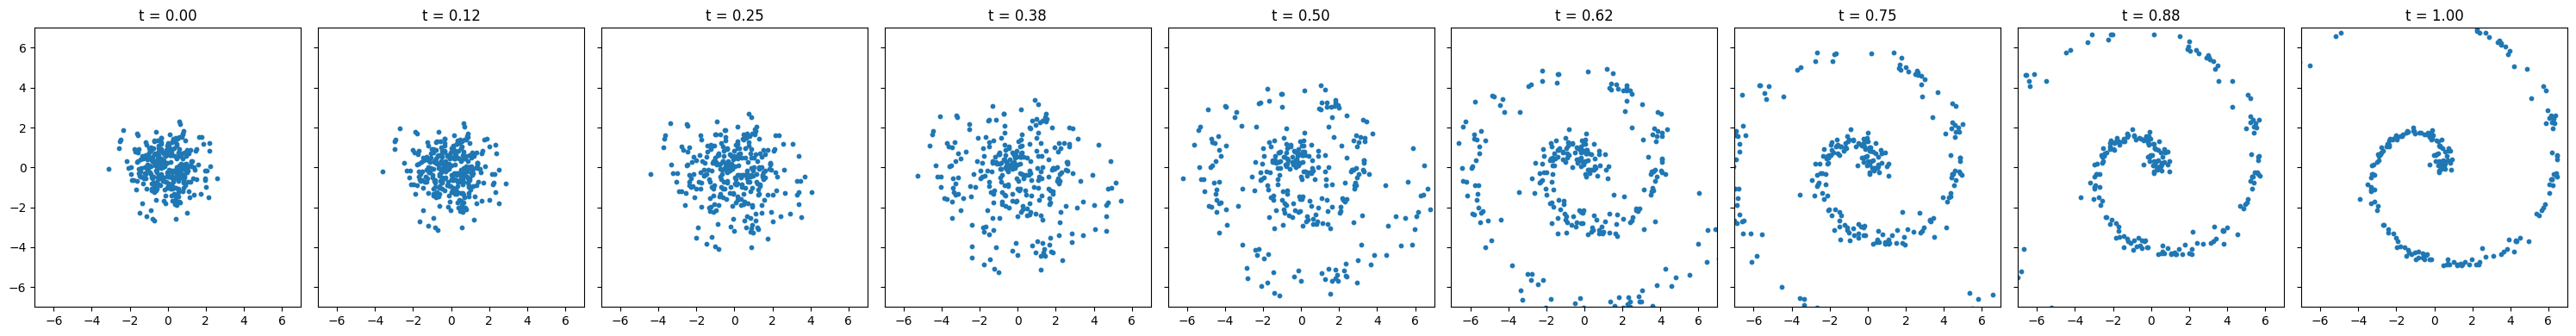

In [ ]:
n_samples = 300
x = torch.randn(n_samples, 2)
n_steps = 8
time_steps = torch.linspace(0,1.0, n_steps+1)

fig, axes = plt.subplots(1, n_steps+1, figsize=(30,4), sharex=True, sharey=True)
for i, t_ in enumerate(time_steps):
    axes[i].scatter(x[:,0].detach(), x[:,1].detach(), s=10)
    axes[i].set_title(f"t = {t_:.2f}")
    axes[i].set_xlim(-7, 7)
    axes[i].set_ylim(-7, 7)
    if i < n_steps:
        x = flow.step(x, time_steps[i], time_steps[i+1])

plt.tight_layout()
plt.savefig("images/flow_output.png")
plt.show()


#### **Sampling and Visualization**

This cell generates a batch of points, evolves them through the learned flow over several time steps, and plots their trajectories.

- **Parameters**  
  - `n_samples = 300`: Number of points to sample.  
  - `n_steps = 8`: Number of integration steps between \(t=0\) and \(t=1\).  
  - `time_steps = torch.linspace(0, 1.0, n_steps+1)`: An array of times from 0 to 1 in equal increments.

- **Initialization**  
  1. Sample `x` from a 2D standard normal:  
     ```python
     x = torch.randn(n_samples, 2)
     ```  
  2. Create a row of subplots with one column per time step (including \(t=0\)). Shared axes keep the same scale.

- **Loop over each time**  
  For each index `i` and time `t_` in `time_steps`:  
  1. Scatter-plot the current points on subplot `axes[i]`.  
  2. Set the title to `t = {t_:.2f}`.  
  3. Fix both x- and y-limits to \([-7, 7]\) for consistency.  
  4. If not at the last time, update `x` by taking one integration step from `time_steps[i]` to `time_steps[i+1]` using the model’s `step` method:
     ```python
     x = flow.step(x, time_steps[i], time_steps[i+1])
     ```

- **Display**  
  - `plt.tight_layout()` nicely adjusts spacing.  
  - `plt.show()` renders the figure with all snapshots of the evolving point cloud.


![Flow Output](images/flow_output.png)

---

# 5. Conclussions


### 1. **Spiral Data Generation**  
   - We replaced the two-moons dataset with a simple Archimedean spiral sampler (`make_spiral`).  
   - This function produces noisy 2D points along \(r = t\) over a specified number of turns.

### 2. **Neural ODE-Style Flow Model**  
   - The `Flow` class defines a small MLP that takes both the current state \((x_t)\) and time \(t\) as input, and outputs a velocity vector \(\dot x\).  
   - Using a 4-layer ELU network, it can approximate arbitrary smooth vector fields in 2D.

### 3. **Training Objective**  
   - We train the flow to match the true displacement \(x_1 - x_0\) between a random “base” noise point \(x_0\) and a target spiral point \(x_1\).  
   - By sampling random interpolation times \(t\in[0,1]\) and minimizing MSE between predicted \(\dot x\) and true \(\Delta x\), the model learns a continuous mapping from Gaussian noise to the spiral distribution.

### 4. **Midpoint Integrator**  
   - A simple two-stage (midpoint) ODE integrator propagates points from \(t\) to \(t + \Delta t\).  
   - This ensures more accurate trajectories than a single Euler step, crucial for preserving the spiral’s shape.

### 5. **Visualization**  
   - Starting from a round cloud of Gaussian noise at \(t=0\), the learned flow gradually warps the points into the spiral by \(t=1.0\).  
   - The sequence of scatter plots shows a smooth, stable interpolation—confirming the model has captured the correct continuous dynamics.

### 6. **Key Takeaway**  
   - Neural ODE flows can learn to transform simple base distributions into complex target shapes via continuous-time dynamics.  
   - Even a small MLP plus a basic integrator suffices to model and visualize this transformation in 2D.
